# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D, MaxPool2D
from keras import backend as K
import itertools

import tensorflow as tf
tf.keras.layers.BatchNormalization()
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
sns.set()


from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing import image
from tensorflow.keras.activations import linear
import cv2

/opt/anaconda3/envs/tf/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Function to plot model's validation loss and validation accuracy

In [2]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy'])+1, int(len(model_history.history['accuracy'])/10)))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss'])+1), range(1, len(model_history.history['loss'])+1, len(model_history.history['loss'])//10))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# Import Data

In [3]:
base_skin_dir = "/Users/rahulchada/Downloads/CNN"

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [5]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/Users/rahulchada/Downloads/CNN/HAM10000_image...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/Users/rahulchada/Downloads/CNN/HAM10000_image...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/Users/rahulchada/Downloads/CNN/HAM10000_image...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/Users/rahulchada/Downloads/CNN/HAM10000_image...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/Users/rahulchada/Downloads/CNN/HAM10000_image...,Benign keratosis-like lesions,2


# Data Cleaning

In [6]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [7]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [8]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [9]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


# Exploratory Data Analysis

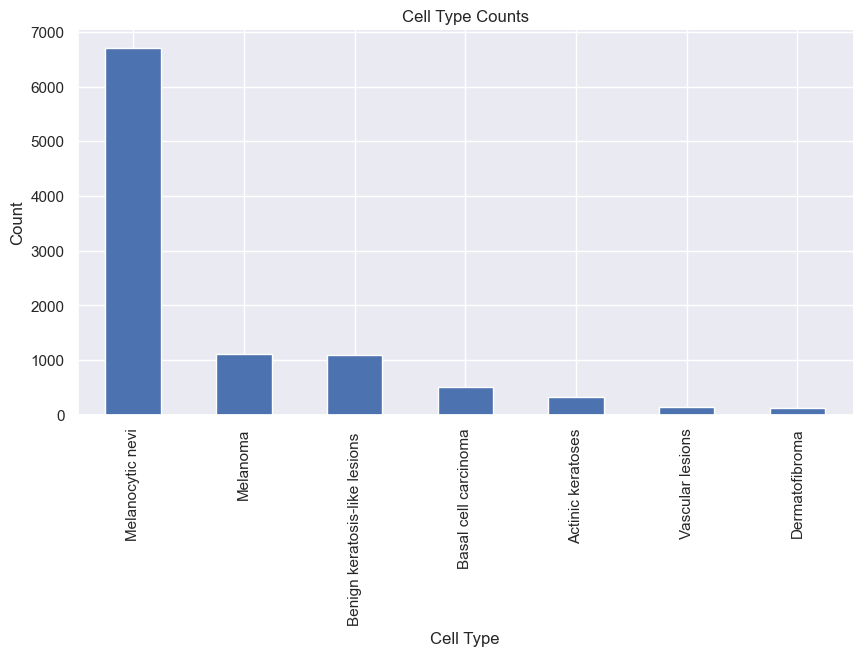

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Cell Type Counts')
ax1.set_xlabel('Cell Type')
ax1.set_ylabel('Count')
sns.despine()
plt.show()

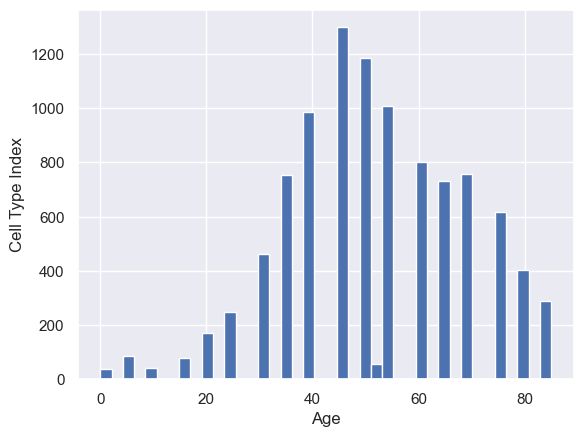

In [11]:
skin_df['age'].hist(bins=40)
plt.xlabel('Age')
plt.ylabel('Cell Type Index')
plt.show()

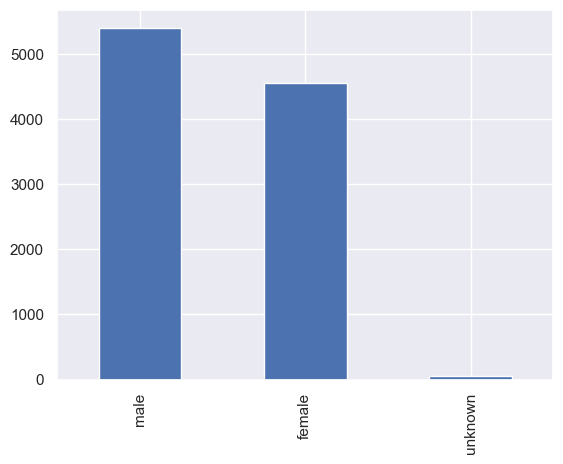

In [12]:
skin_df['sex'].value_counts().plot(kind='bar')
plt.show()

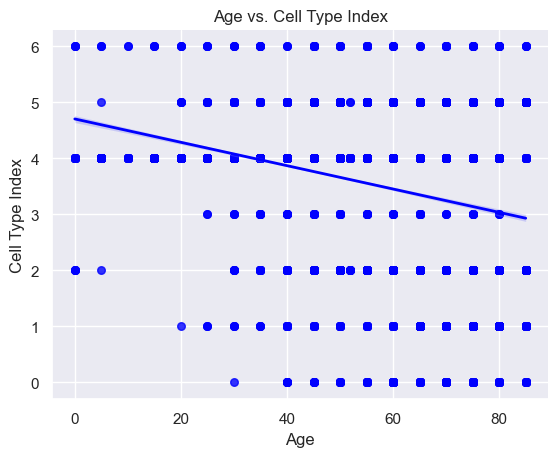

In [13]:
sns.regplot(data=skin_df, x='age', y='cell_type_idx', color='blue', scatter_kws={'s': 30}, line_kws={'linewidth': 2})
plt.title('Age vs. Cell Type Index')
plt.xlabel('Age')
plt.ylabel('Cell Type Index')
sns.despine()
plt.show()

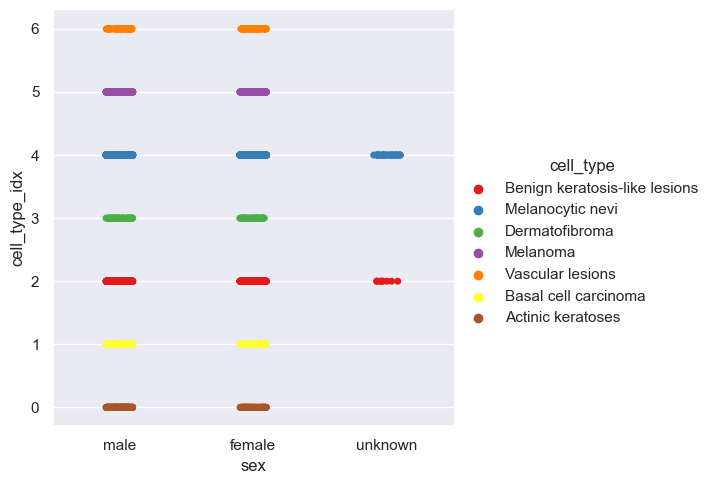

In [14]:
sns.catplot(data=skin_df,x='sex',y='cell_type_idx', hue='cell_type', palette='Set1')
plt.show()

# Loading and resizing of images

In [15]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [16]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/Users/rahulchada/Downloads/CNN/HAM10000_image...,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/Users/rahulchada/Downloads/CNN/HAM10000_image...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/Users/rahulchada/Downloads/CNN/HAM10000_image...,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/Users/rahulchada/Downloads/CNN/HAM10000_image...,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/Users/rahulchada/Downloads/CNN/HAM10000_image...,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


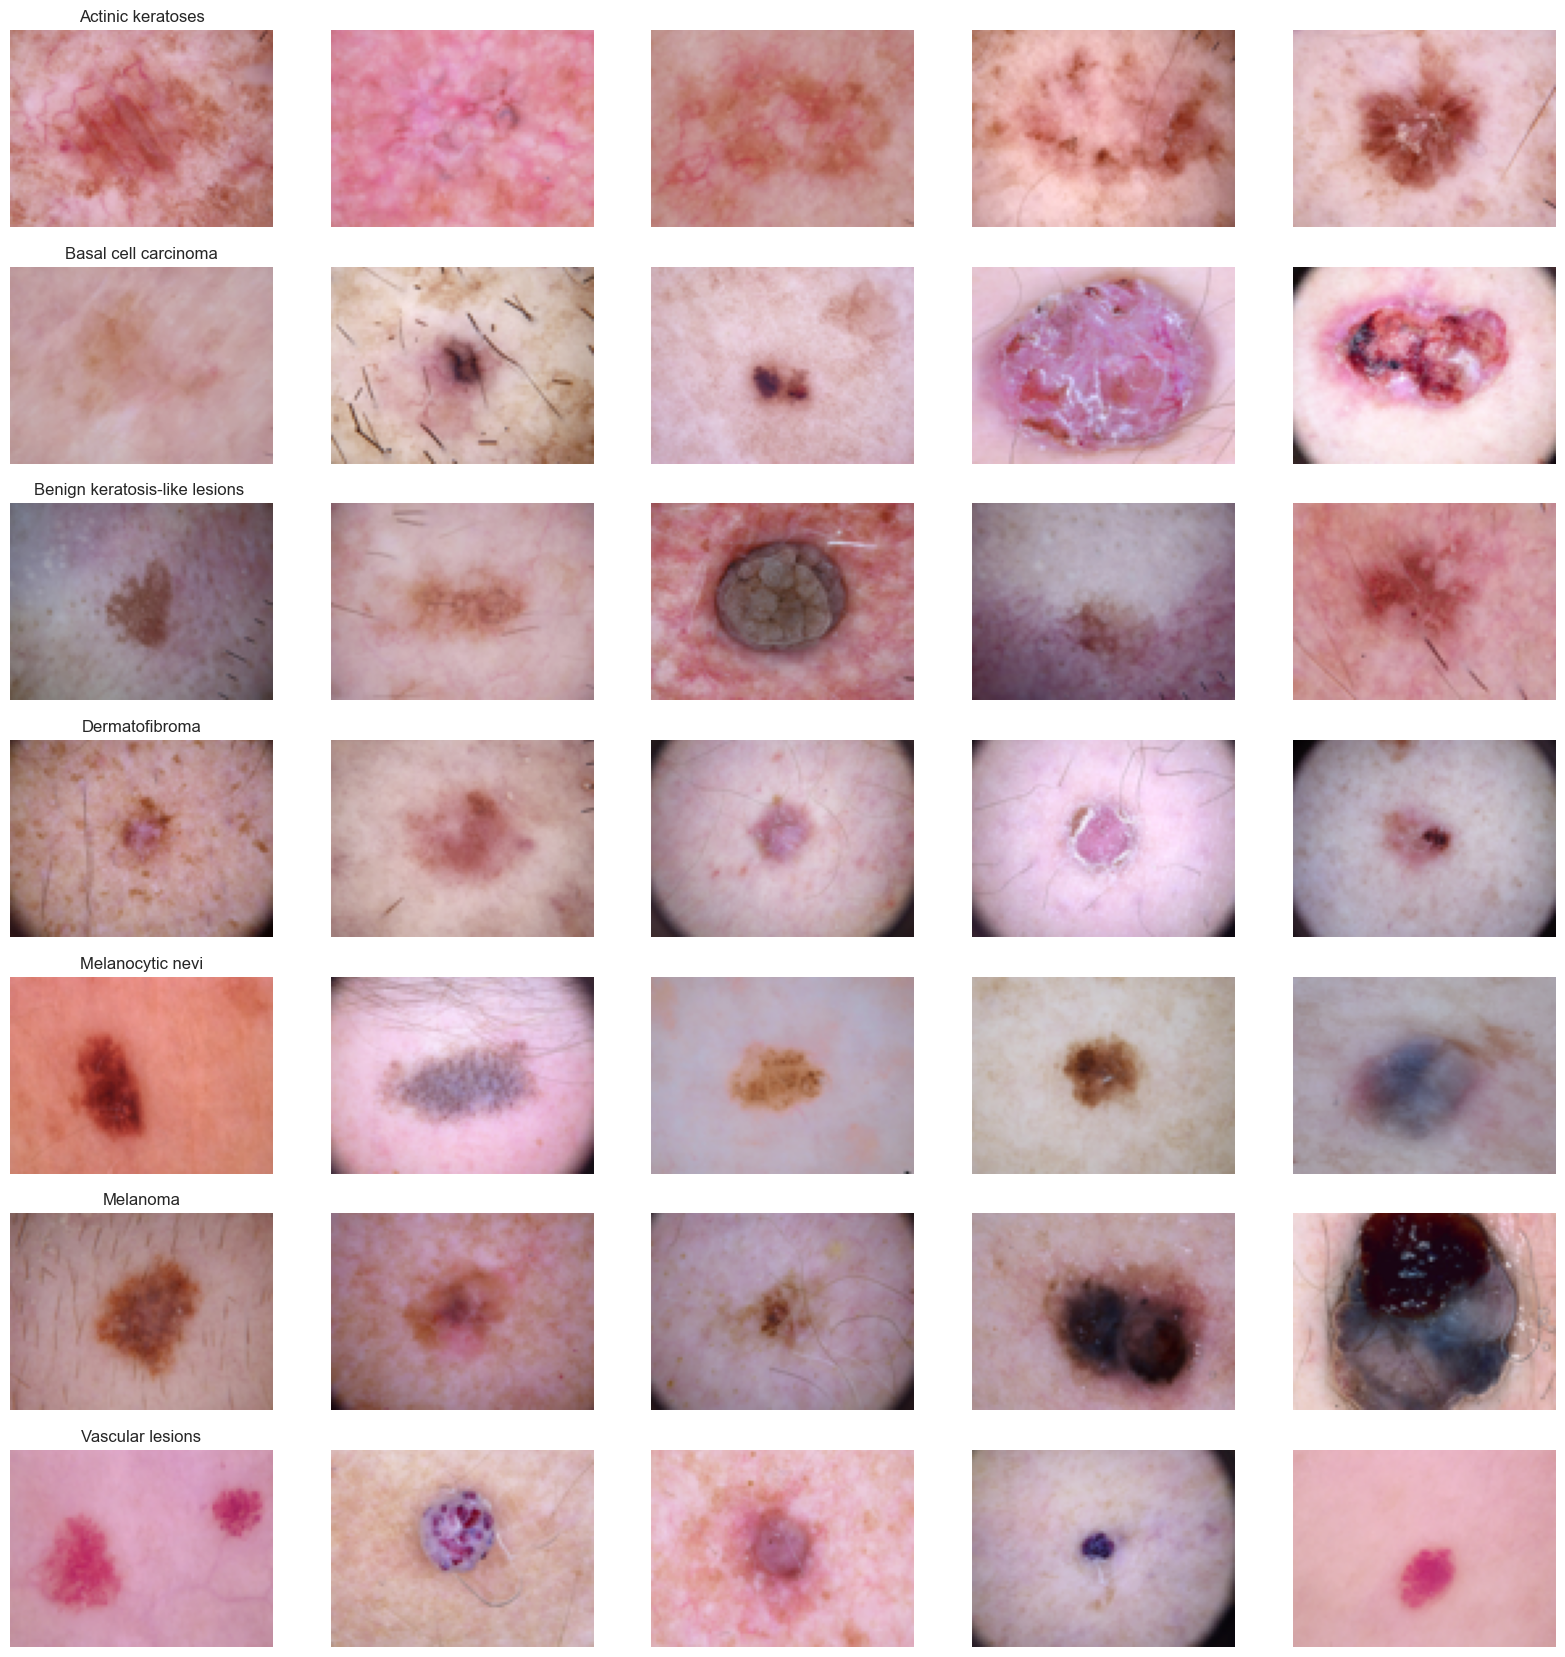

In [17]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [18]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [19]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

# Train/Test Split

In [20]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=123)

# Normalization

In [21]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Label Encoding

In [22]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

# Train/Valid Spit

In [23]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

In [24]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

# Model Building

In [25]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import regularizers

input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 100, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 50, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 37, 50, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 50, 64)        36928     
                                                        

2023-05-02 03:43:34.658860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
# Compile the model
model.compile(optimizer = "adam" , 
              loss = "sparse_categorical_crossentropy", 
              metrics=["accuracy"])

In [27]:
y_train = [x.index(1) for x in y_train.tolist()] 
y_test = [x.index(1) for x in y_test.tolist()]
y_validate = [x.index(1) for x in y_validate.tolist()]

# Data Augumentation

In [28]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

# Model Training

In [29]:
epochs = 10 
batch_size = 10

history = model.fit(datagen.flow(np.array(x_train),np.array(y_train), batch_size=batch_size),
                    epochs = epochs, validation_data = (np.array(x_validate),np.array(y_validate)),
                    verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)


Epoch 1/10
721/721 [==============================] - 83s 114ms/step - loss: 1.0067 - accuracy: 0.6712 - val_loss: 0.9302 - val_accuracy: 0.6559
Epoch 2/10
721/721 [==============================] - 85s 118ms/step - loss: 0.8952 - accuracy: 0.6750 - val_loss: 0.8850 - val_accuracy: 0.6633
Epoch 3/10
721/721 [==============================] - 88s 122ms/step - loss: 0.8728 - accuracy: 0.6806 - val_loss: 0.9196 - val_accuracy: 0.6683
Epoch 4/10
721/721 [==============================] - 88s 123ms/step - loss: 0.8534 - accuracy: 0.6865 - val_loss: 0.8408 - val_accuracy: 0.6808
Epoch 5/10
721/721 [==============================] - 88s 123ms/step - loss: 0.8283 - accuracy: 0.7000 - val_loss: 0.8270 - val_accuracy: 0.6995
Epoch 6/10
721/721 [==============================] - 89s 124ms/step - loss: 0.8217 - accuracy: 0.7028 - val_loss: 0.8448 - val_accuracy: 0.7007
Epoch 7/10
721/721 [==============================] - 548s 761ms/step - loss: 0.7993 - accuracy: 0.7144 - val_loss: 0.7907 - val_a

# Model Evaluation

In [72]:
loss, accuracy = model.evaluate(np.array(x_test), np.array(y_test), verbose=1)
loss_v, accuracy_v = model.evaluate(np.array(x_validate), np.array(y_validate), verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

26/26 [==============================] - 2s 84ms/step - loss: 0.7712 - accuracy: 0.7182
Validation: accuracy = 0.718204  ;  loss_v = 0.771227
Test: accuracy = 0.707938  ;  loss = 0.755129


# Function to plot model's validation loss and validation accuracy

In [31]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy'])+1, int(len(model_history.history['accuracy'])/10)))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss'])+1), range(1, len(model_history.history['loss'])+1, len(model_history.history['loss'])//10))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

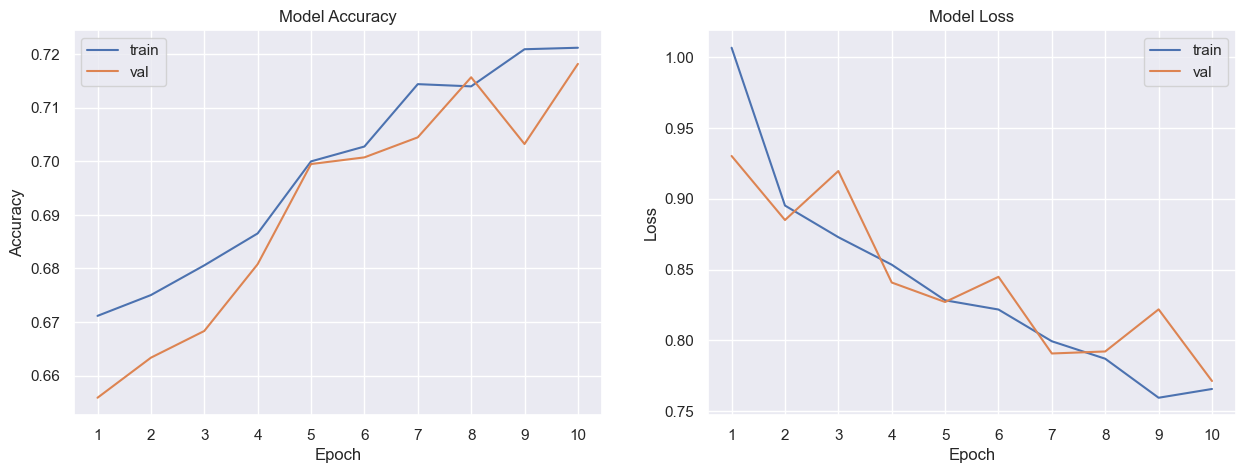

In [32]:
plot_model_history(history)

# Noice addition

In [73]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
datagen.fit(x_test)

# Evaluating after noice addition

In [74]:
gen_test = datagen.flow(x_test, y_test)

In [77]:
loss, accuracy_noice = model.evaluate(gen_test, verbose=2)

63/63 - 6s - loss: 0.7815 - accuracy: 0.7109 - 6s/epoch - 99ms/step


# comparing results

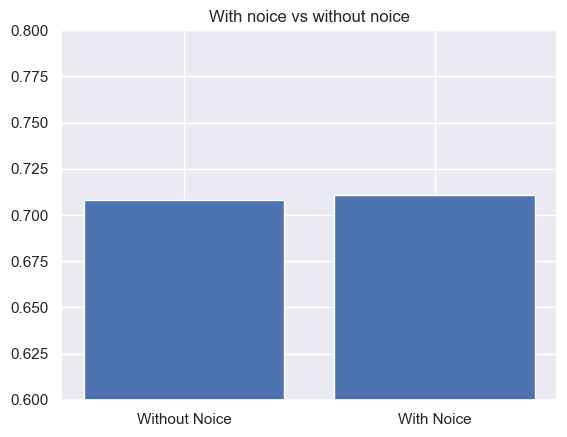

In [78]:
plt.bar(["Without Noice", "With Noice"], [accuracy, accuracy_noice])
plt.ylim(0.6,0.8)
plt.title("With noice vs without noice")
plt.show()

In [33]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import regularizers

input_shape = (75, 100, 3)
num_classes = 7

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers in the base InceptionV3 model
for layer in base_model.layers:
    layer.trainable = False

# Add new classifier layers on top of the InceptionV3 base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the final model by combining the base InceptionV3 model and the new classifier layers
model_tl = Model(inputs=base_model.input, outputs=predictions)

model_tl.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 100, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 37, 49, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 37, 49, 32)  96          ['conv2d_4[0][0]']               
 rmalization)                                                                                     
                                                                                              

 batch_normalization_11 (BatchN  (None, 7, 10, 96)   288         ['conv2d_14[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_12 (BatchN  (None, 7, 10, 32)   96          ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 7, 10, 64)    0           ['batch_normalization_6[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 7, 10, 64)    0           ['batch_normalization_8[0][0]']  
                                                                                                  
 activatio

 conv2d_24 (Conv2D)             (None, 7, 10, 48)    13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_27 (Conv2D)             (None, 7, 10, 96)    55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_21 (BatchN  (None, 7, 10, 48)   144         ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_24 (BatchN  (None, 7, 10, 96)   288         ['conv2d_27[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_38 (Conv2D)             (None, 3, 4, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_35 (BatchN  (None, 3, 4, 128)   384         ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 3, 4, 128)    0           ['batch_normalization_35[0][0]'] 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 3, 4, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 3, 4, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_49 (Conv2D)             (None, 3, 4, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_46 (BatchN  (None, 3, 4, 160)   480         ['conv2d_49[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 3, 4, 160)    0           ['batch_normalization_46[0][0]'] 
                                                                                                  
 conv2d_45

 batch_normalization_56 (BatchN  (None, 3, 4, 160)   480         ['conv2d_59[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 3, 4, 160)    0           ['batch_normalization_56[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 3, 4, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_60 (Conv2D)             (None, 3, 4, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_52 (BatchN  (None, 3, 4, 160)   480         ['conv2d_55[0][0]']              
 ormalizat

 conv2d_65 (Conv2D)             (None, 3, 4, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 3, 4, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_62 (BatchN  (None, 3, 4, 192)   576         ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_67 (BatchN  (None, 3, 4, 192)   576         ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_75 (BatchN  (None, 3, 4, 192)   576         ['conv2d_78[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 3, 4, 192)    0           ['batch_normalization_71[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 3, 4, 192)    0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 conv2d_75 (Conv2D)             (None, 1, 1, 320)    552960      ['activation_70[0][0]']          
          

                                                                                                  
 activation_82 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_84[0][0]'] 
                                                                                                  
 batch_normalization_85 (BatchN  (None, 1, 1, 192)   576         ['conv2d_88[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 1, 1, 320)    0           ['batch_normalization_77[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 1, 1, 320)    0           ['batch_normalization_86[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 1, 1, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 1, 1, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

In [34]:
# Compile the model
model_tl.compile(optimizer = "adam" , 
              loss = "sparse_categorical_crossentropy", 
              metrics=["accuracy"])

In [36]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_validate = np.array(y_validate)

In [37]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [38]:
epochs = 10 
batch_size = 10

history = model_tl.fit(datagen.flow(np.array(x_train),np.array(y_train), batch_size=batch_size),
                    epochs = epochs, validation_data = (np.array(x_validate),np.array(y_validate)),
                    verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)


Epoch 1/10
721/721 [==============================] - 51s 67ms/step - loss: 1.2568 - accuracy: 0.6606 - val_loss: 0.9319 - val_accuracy: 0.6920
Epoch 2/10
721/721 [==============================] - 47s 66ms/step - loss: 0.9289 - accuracy: 0.6877 - val_loss: 0.9179 - val_accuracy: 0.6908
Epoch 3/10
721/721 [==============================] - 50s 70ms/step - loss: 0.9180 - accuracy: 0.6917 - val_loss: 0.9561 - val_accuracy: 0.6758
Epoch 4/10
721/721 [==============================] - 49s 68ms/step - loss: 0.9108 - accuracy: 0.6946 - val_loss: 1.0106 - val_accuracy: 0.6696
Epoch 5/10
721/721 [==============================] - 52s 72ms/step - loss: 0.9035 - accuracy: 0.6928 - val_loss: 0.9250 - val_accuracy: 0.6696
Epoch 6/10
721/721 [==============================] - 53s 73ms/step - loss: 0.9029 - accuracy: 0.6942 - val_loss: 0.8958 - val_accuracy: 0.6970
Epoch 7/10
721/721 [==============================] - 51s 71ms/step - loss: 0.8859 - accuracy: 0.6936 - val_loss: 0.8983 - val_accuracy:

In [39]:
loss, accuracy = model_tl.evaluate(np.array(x_test), np.array(y_test), verbose=1)
loss_v, accuracy_v = model_tl.evaluate(np.array(x_validate), np.array(y_validate), verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model_tl.save("model.h5")

26/26 [==============================] - 4s 149ms/step - loss: 0.8793 - accuracy: 0.6820
Validation: accuracy = 0.682045  ;  loss_v = 0.879286
Test: accuracy = 0.686470  ;  loss = 0.838245


# Noice addition

In [40]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
datagen.fit(x_test)

# Evaluating after noice addition

In [41]:
gen_test = datagen.flow(x_test, y_test)

In [42]:
loss, accuracy_noice = model.evaluate(gen_test, verbose=2)

63/63 - 7s - loss: 0.7726 - accuracy: 0.7044 - 7s/epoch - 110ms/step


# comparing results

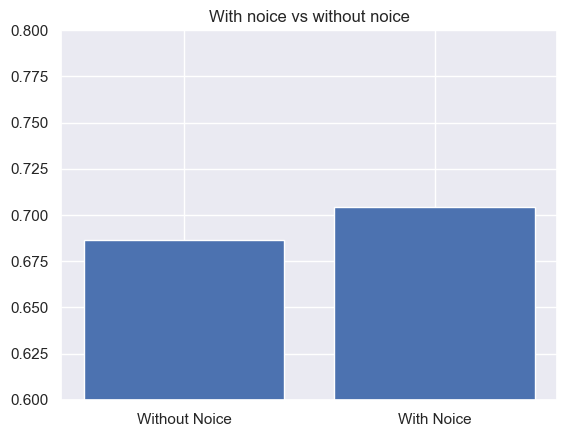

In [43]:
plt.bar(["Without Noice", "With Noice"], [accuracy, accuracy_noice])
plt.ylim(0.6,0.8)
plt.title("With noice vs without noice")
plt.show()

# t-SNE visualization

In [44]:
class_names = {
    0: 'Melanocytic nevi',
    1: 'Melanoma',
    2: 'Benign keratosis-like lesions',
    3: 'Basal cell carcinoma',
    4: 'Actinic keratoses',
    5: 'Vascular lesions',
    6: 'Dermatofibroma'
}
    
def plot_tsne(model_tl, x_test, y_test):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[-4].output)
    intermediate_output = intermediate_layer_model.predict(x_test)
    tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=400)
    tsne_results = tsne.fit_transform(intermediate_output)
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    fig, ax = plt.subplots(figsize=(10, 8))
    for i in range(len(class_names)):
        ax.scatter(tsne_results[y_test == i, 0], tsne_results[y_test == i, 1], 
                   color=colors[i], label=class_names[i], 
                   alpha=0.5, edgecolor='k', s=50)
    ax.legend()
    plt.show()

63/63 [==============================] - 6s 102ms/step


/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2003 samples in 0.026s...
[t-SNE] Computed neighbors for 2003 samples in 3.545s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2003
[t-SNE] Computed conditional probabilities for sample 2000 / 2003
[t-SNE] Computed conditional probabilities for sample 2003 / 2003
[t-SNE] Mean sigma: 0.730254
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.980911
[t-SNE] KL divergence after 400 iterations: 1.080998


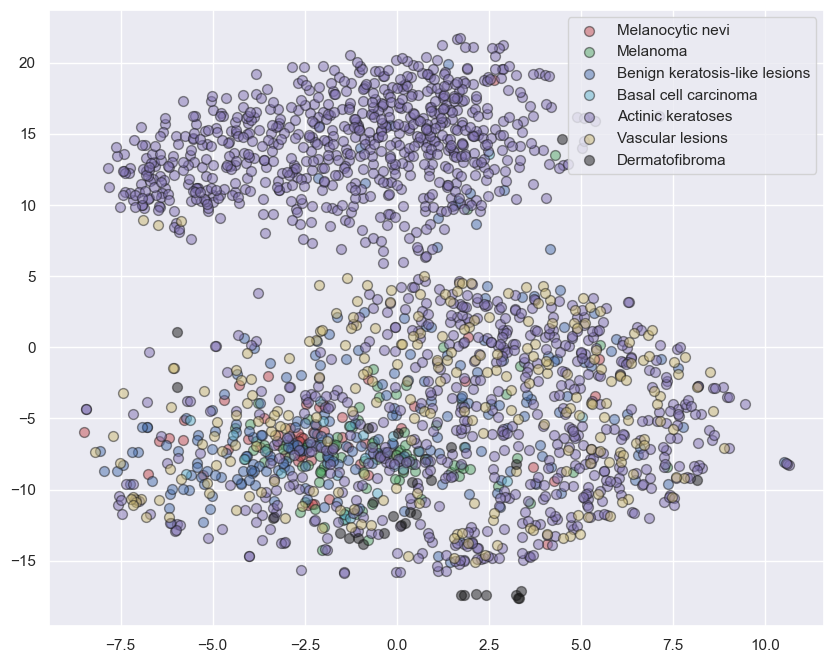

In [45]:
plot_tsne(model_tl, x_test, y_test)

# ROC analysis

In [64]:
from sklearn.preprocessing import LabelBinarizer

def plot_roc(model, x_test, y_test):
    y_pred = model.predict(x_test)
    n_classes = y_pred.shape[1]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    else:
        lb = LabelBinarizer()
        lb.fit(y_test)
        y_test = lb.transform(y_test)
        
        fpr = {}
        tpr = {}
        roc_auc = {}
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
            
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

63/63 [==============================] - 9s 140ms/step


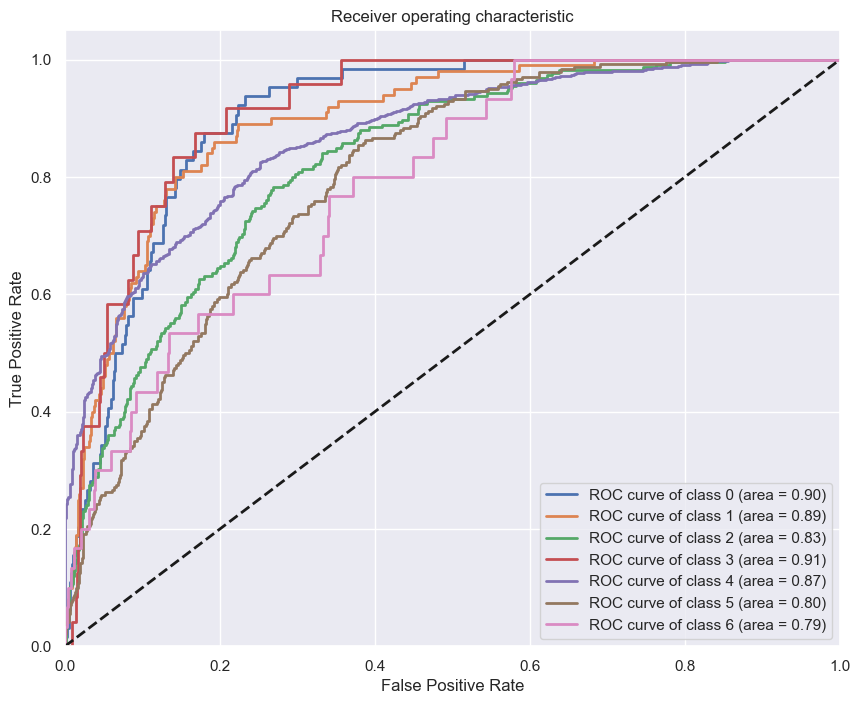

In [65]:
plot_roc(model_tl, x_test, y_test)